# PUI_2016 - HW12 - Extra Credit

In [17]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from geopandas import GeoDataFrame
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist, squareform
import seaborn
import zipfile as zf
import pylab as pl
%matplotlib inline


In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [3]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''SELECT count(zipcodes), zipcodes 
                   FROM nycasthmasdismissals
                   GROUP BY zipcodes;
                '''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [5]:
# Download the shape file with zipcode shapes for NYC
os.system('curl -O https://data.cityofnewyork.us/api/file_data/' + 
          'YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip')
os.system('mv YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip ZIP_CODE_040114.zip')

zip_ref = zf.ZipFile('ZIP_CODE_040114.zip', 'r')
zip_ref.extractall(os.getenv('PUIDATA') + '/ZIP_CODE_040114')

In [6]:
shape_path= os.getenv("PUIDATA") + "/ZIP_CODE_040114/ZIP_CODE_040114.shp"
zip_shape = GeoDataFrame.from_file(shape_path)
zip_shape.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


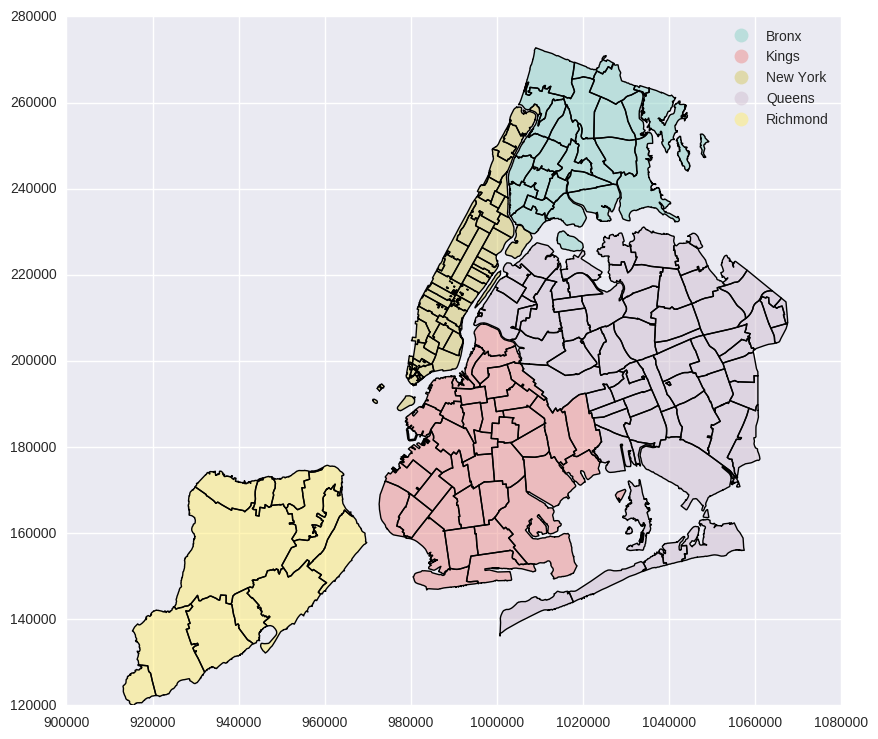

In [7]:
zip_shape.plot(figsize=(10,10), column='COUNTY', legend=True, cmap='Set3')

### Figure XX - New York City Map segregated by Counties.

In [8]:
zip_shape.ZIPCODE = pd.to_numeric(zip_shape.ZIPCODE)
zip_shape = zip_shape.merge(facilities, right_on='zipcodes', left_on='ZIPCODE')
zip_shape = zip_shape.iloc[:,-3:]
zip_shape['centers'] = zip_shape.centroid

zip_shape = zip_shape.iloc[:,-3:]
zip_shape.head()

,count,zipcodes,centers
0,376,11213,POINT (1001912.871996466 183803.1131420481)
1,713,11212,POINT (1008365.375095716 180768.9448568909)
2,421,11219,POINT (985172.779324743 169813.4852984693)
3,494,10466,POINT (1026647.114925691 263909.2896452093)
4,2164,10467,POINT (1020059.119296007 259287.5178783316)


## Create a 3xN numpy array with x-location, y-location, number of dismissals

In [9]:
krigdata = np.zeros((len(zip_shape),3))

In [10]:
for i in range(len(zip_shape)):
    krigdata[i,0] = zip_shape['centers'][i].coords[0][0]
    krigdata[i,1] = zip_shape['centers'][i].coords[0][1]
    krigdata[i,2] = zip_shape['count'][i]

krigdata

array([[  1.00191287e+06,   1.83803113e+05,   3.76000000e+02],
       [  1.00836538e+06,   1.80768945e+05,   7.13000000e+02],
       [  9.85172779e+05,   1.69813485e+05,   4.21000000e+02],
       [  1.02664711e+06,   2.63909290e+05,   4.94000000e+02],
       [  1.02005912e+06,   2.59287518e+05,   2.16400000e+03],
       [  1.02829272e+06,   2.47902428e+05,   1.69900000e+03],
       [  1.01237400e+06,   2.47427241e+05,   8.22000000e+02],
       [  1.00976434e+06,   2.41746681e+05,   1.07200000e+03],
       [  1.00535896e+06,   2.38316068e+05,   1.69800000e+03],
       [  1.00461252e+06,   2.20393721e+05,   2.81000000e+02],
       [  1.03375196e+06,   2.13025445e+05,   6.41000000e+02],
       [  1.00620449e+06,   1.95763534e+05,   1.15600000e+03],
       [  1.00021475e+06,   1.95030042e+05,   4.66000000e+02],
       [  9.87194513e+05,   1.92431928e+05,   9.40000000e+02],
       [  9.89857162e+05,   1.81769963e+05,   5.21000000e+02],
       [  1.00248639e+06,   1.75967925e+05,   1.8290000

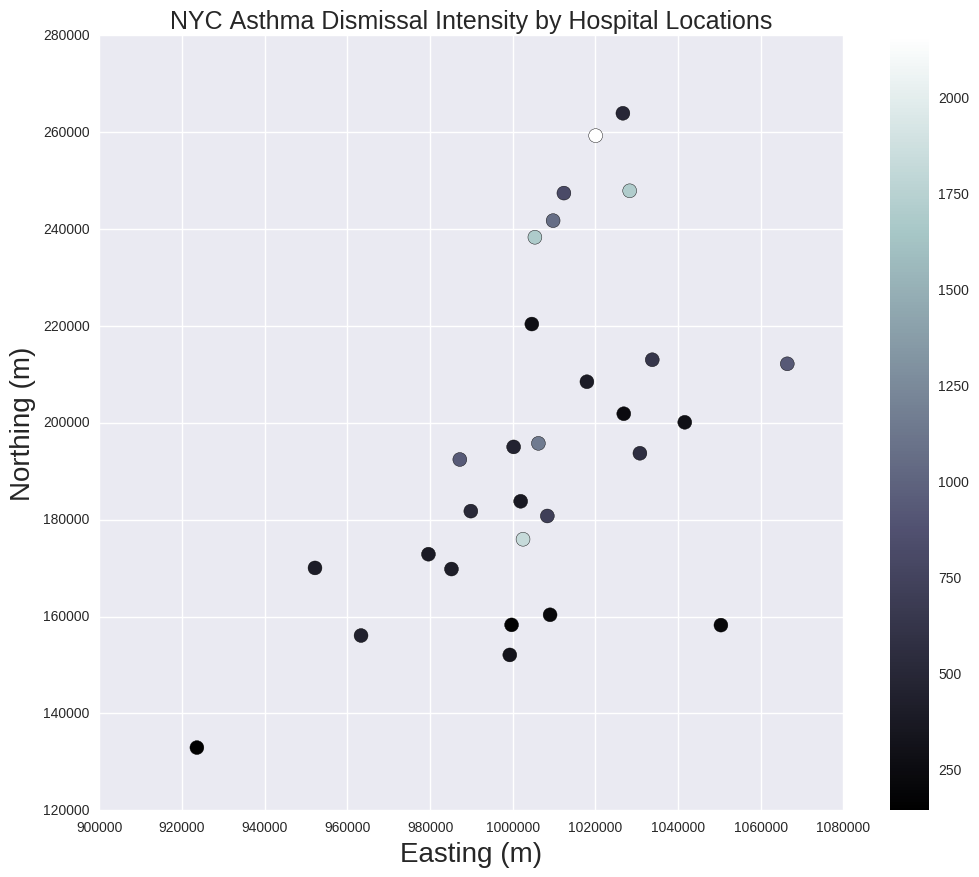

In [11]:
plt.figure(figsize=(12,10))
plt.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
plt.title('NYC Asthma Dismissal Intensity by Hospital Locations', fontsize=18)
plt.xlabel("Easting (m)", fontsize=20)
plt.ylabel("Northing (m)", fontsize=20)
plt.colorbar()

### Figure 2: The plot above shows Asthma Dismissal counts by location of NYC Hospitals on a Northing vs. Easting cordinate space.

### Create and try to model the semi-variogram as we did in class
https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
### Explain what is going on

In [12]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    P data
    h lag
    bw max distance
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    N = pdsv.shape[0]
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    Z = Z.T + P[:,2]
    Z = Z**2
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )


def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    # Distance matrix (Eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    N = pdsv.shape[0]

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [13]:
lag = 400
mysv = SV( krigdata, np.arange(1, 40000, lag), 1000 )

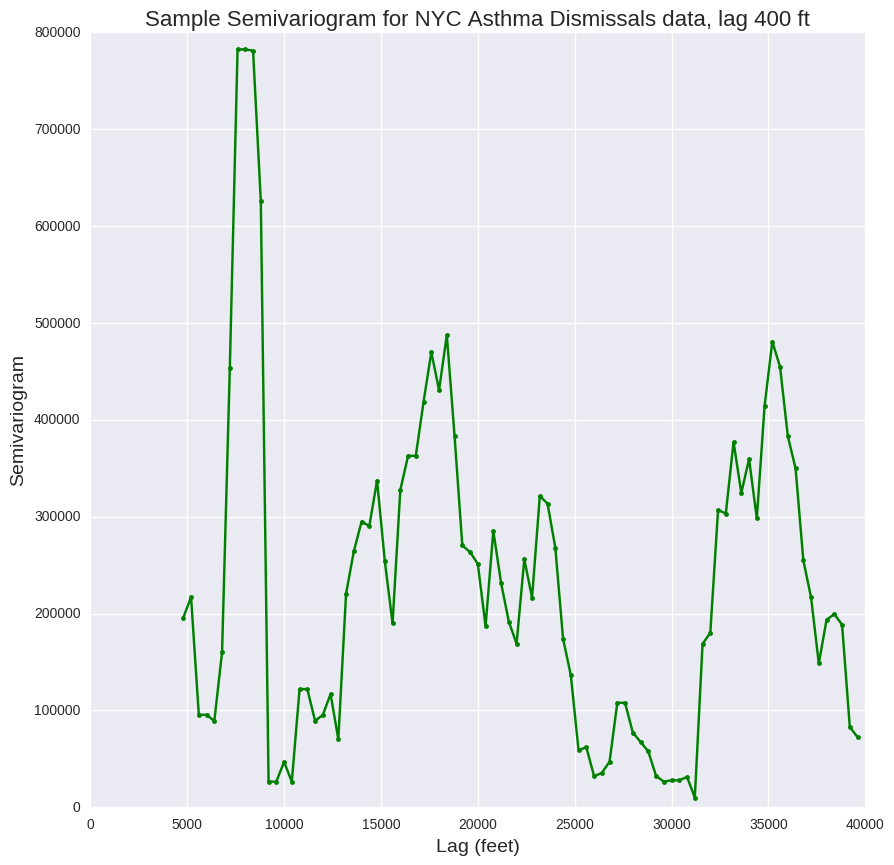

In [14]:
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 10500, lag)
#mysv = SV( x, hs, bw )
plt.figure(figsize=(10,10))
plt.plot( mysv[0], mysv[1], '.-', c='g')
plt.xlabel('Lag (feet)', fontsize=14)
plt.ylabel('Semivariogram', fontsize=14)
plt.title('Sample Semivariogram for NYC Asthma Dismissals data, lag %d ft'%lag, fontsize=16)

#### Figure 2: Semivariogram - 
* **lag on the x-axis measures the distance between points**
* **y-axis shows how similar points are to each other based on the plotted distance.**

**This ad hoc pattern semivariogram pattern gives no relationship between hospitals and asthma dismissals.**